In [77]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [65]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [66]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

In [67]:
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

In [68]:
len(train_data)

60000

In [69]:
len(test_data)

10000

In [70]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True
)

In [71]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(images.min(), images.max())

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [72]:
output = len(train_data.classes)

In [73]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [74]:
class MNIST_Model_VGG(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*7*7, out_features=output)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    
model = MNIST_Model_VGG(input=1, hidden=16, output=output).to(device)
model


MNIST_Model_VGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [76]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 10

for epoch in range(epochs):
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        y_train_logits = model(X)
        y_train_loss = criterion(y_train_logits, y)
        y_train_preds = torch.argmax(y_train_logits, dim=1)
        y_train_acc = (y_train_preds == y).float().mean()
        optimizer.zero_grad()
        y_train_loss.backward()
        optimizer.step()

    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = torch.tensor(y, dtype=torch.long).to(device)
            y_test_logits = model(X)
            y_test_loss = criterion(y_test_logits, y)
            y_test_preds = torch.argmax(y_test_logits, dim=1)
            y_test_acc = (y_test_preds == y).float().mean()
    print(
        f"Epoch: {epoch} || Train Loss: {y_train_loss:.4f} || Train Acc: {y_train_acc:.4f} || Test Loss: {y_test_loss:.4f} || Test Acc: {y_test_acc:.4f}")

/var/folders/_2/_yhjp4h153l3658w2fh53v580000gn/T/ipykernel_84060/507701040.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)
/var/folders/_2/_yhjp4h153l3658w2fh53v580000gn/T/ipykernel_84060/507701040.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)


Epoch: 0 | Train Loss: 2.3035 | Train Acc: 0.0938 | Test Loss: 2.2928 | Test Acc: 0.1250
Epoch: 1 | Train Loss: 2.2919 | Train Acc: 0.2500 | Test Loss: 2.3114 | Test Acc: 0.0000
Epoch: 2 | Train Loss: 2.2822 | Train Acc: 0.2188 | Test Loss: 2.2981 | Test Acc: 0.1875
Epoch: 3 | Train Loss: 2.2904 | Train Acc: 0.1250 | Test Loss: 2.2837 | Test Acc: 0.0625
Epoch: 4 | Train Loss: 2.2630 | Train Acc: 0.5000 | Test Loss: 2.2522 | Test Acc: 0.3125
Epoch: 5 | Train Loss: 2.0667 | Train Acc: 0.5000 | Test Loss: 1.9590 | Test Acc: 0.7500
Epoch: 6 | Train Loss: 0.6591 | Train Acc: 0.8125 | Test Loss: 0.7450 | Test Acc: 0.7500
Epoch: 7 | Train Loss: 0.4956 | Train Acc: 0.8750 | Test Loss: 0.4255 | Test Acc: 0.8125
Epoch: 8 | Train Loss: 0.3869 | Train Acc: 0.8125 | Test Loss: 0.1054 | Test Acc: 1.0000
Epoch: 9 | Train Loss: 0.1982 | Train Acc: 0.9688 | Test Loss: 0.3814 | Test Acc: 0.9375


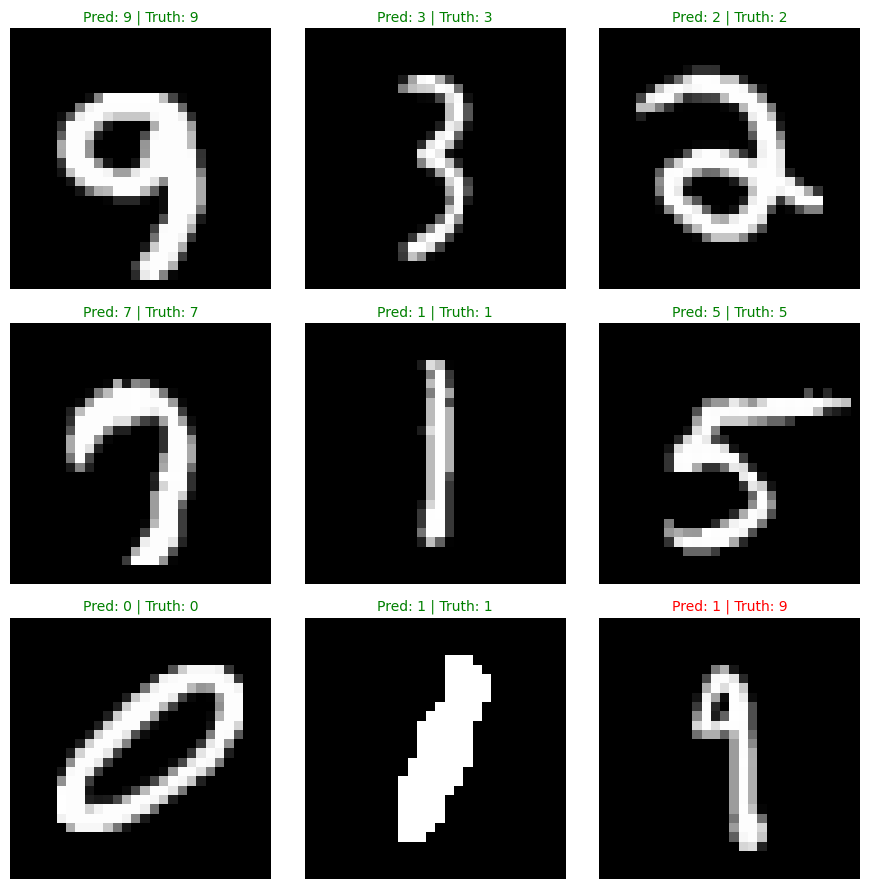

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i in range(min(nrows * ncols, X.shape[0])):
    plt.subplot(nrows, ncols, i + 1)

    img = X[i]
    if img.ndim == 3:
        img = img.squeeze()

    plt.imshow(img.cpu(), cmap="gray")

    pred_label = int(y_test_preds[i])
    truth_label = int(y[i])

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    plt.title(
        title_text,
        fontsize=10,
        c="g" if pred_label == truth_label else "r"
    )

    plt.axis(False)

plt.tight_layout()
plt.show()
